## Long Short Term Memory Networks (LSTM)

__Attach this notebook to `class.ma707.test`.__

## Reference
- https://docs.databricks.com/applications/deep-learning/single-node-training/keras.html#install-keras
- https://docs.databricks.com/applications/deep-learning/index.html
- https://stackoverflow.com/questions/38714959/understanding-keras-lstms
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Notes
- LSTM networks are able to "remember" patterns (most other neural networks to not) so they are useful for time series.

## 0. Setup

In [6]:
%sh ls -hot /dbfs/mnt/group-ma707/data/*

-rw-r--r-- 1 root 259K Jan 29 17:44 /dbfs/mnt/group-ma707/data/5tc_plus_ind_vars.csv
-rw-r--r-- 1 root 12M Jan 29 17:44 /dbfs/mnt/group-ma707/data/mining_com_coal.csv
-rw-r--r-- 1 root 11M Jan 29 17:44 /dbfs/mnt/group-ma707/data/mining_com_iron_ore.csv

In [7]:
bci_filepath = '/dbfs/mnt/group-ma707/data/5tc_plus_ind_vars.csv'

In [8]:
%python
import pandas as pd
bci_pdf = pd.read_csv(bci_filepath) \
            .rename(columns={'P3A~IV':'P3A_IV'}) \
            .assign(date=lambda pdf: pd.to_datetime(pdf.Date)) \
            .drop('Date', axis=1) \
            .sort_index(ascending=True)
bci_pdf.columns = bci_pdf.columns.str.lower()
bci_pdf.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 26 columns):
bci 1602 non-null int64
c5 1602 non-null float64
c7 1602 non-null float64
p1a_03 1602 non-null int64
p2a_03 1602 non-null int64
p4_03 1602 non-null int64
p3a_iv 1602 non-null float64
shfe_al3 1602 non-null float64
rici 1602 non-null float64
ice_kc3 1602 non-null float64
cme_sm3 1602 non-null float64
cme_lc2 1602 non-null float64
opec_orb 1602 non-null float64
shfe_cu3 1602 non-null float64
cme_ln1 1602 non-null float64
cme_fc3 1602 non-null float64
p3a_03 1602 non-null int64
shfe_rb3 1602 non-null int64
cme_s2 1602 non-null float64
ice_sb3 1602 non-null float64
cme_ln3 1602 non-null float64
cme_ln2 1602 non-null float64
ice_tib3 1602 non-null float64
ice_tib4 1602 non-null float64
bci_5tc 1602 non-null int64
date 1602 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(18), int64(7)
memory usage: 325.5 KB

In [9]:
def display_pdf(a_pdf):
  display(spark.createDataFrame(a_pdf,verifySchema=False))

In [10]:
def est_grid_results_pdf(my_est_grid_obj,est_tag=None,fea_tag=None): 
  import pandas as pd
  import numpy  as np
  res_pdf = pd.DataFrame(data=my_est_grid_obj.cv_results_) \
           .loc[:,lambda df: np.logical_or(df.columns.str.startswith('param_'),
                                           df.columns.str.endswith('test_score'))
               ] \
           .loc[:,lambda df: np.logical_not(df.columns.str.startswith('split'))
               ] \
           .drop(['rank_test_score', 'std_test_score'], 
                 axis=1)
  res_pdf.columns = [column.replace('param_','') for column in list(res_pdf.columns)]
  if est_tag is not None: res_pdf = res_pdf.assign(est_tag=est_tag)
  if fea_tag is not None: res_pdf = res_pdf.assign(fea_tag=fea_tag)
  return res_pdf.sort_values('mean_test_score')

In [11]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

--------------------------------------------------------------------------- 
 ImportError Traceback (most recent call last)
 <command-1445178> in <module> () 
 8 from sklearn . preprocessing import LabelEncoder 
 9 from sklearn . metrics import mean_squared_error 
 ---> 10 from keras . models import Sequential 
 11 from keras . layers import Dense 
 12 from keras . layers import LSTM 

 ImportError : No module named 'keras'

In [12]:
%run "../Report/0.2 Feature creation (inc)"

In [13]:
def create_train_test_ts(fea_pdf, tgt_ser, trn_prop=0.8):
  trn_len = int(trn_prop * len(fea_pdf))
  return (fea_pdf.iloc[:trn_len],
          fea_pdf.iloc[ trn_len:],
          tgt_ser.iloc[:trn_len],
          tgt_ser.iloc[ trn_len:]
         )

In [14]:
def plot_comparison(test_p, test_y):
  pyplot.clf()
  pyplot.plot(test_y, label='actual')
  pyplot.plot(test_p, label='predicted')
  pyplot.legend()
  display(pyplot.show())

In [15]:
def plot_history():
  pyplot.clf()
  pyplot.plot(history.history['loss']    , label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  display(pyplot.show())

In [16]:
def plot_actual(target_ser):
  import numpy as np
  pyplot.clf()
  pyplot.plot(target_ser,label='actual')
  pyplot.legend()
  display(pyplot.show())

## 1. Multivariable time series

In [18]:
from sklearn.base import BaseEstimator, RegressorMixin
from keras.layers import LSTM
class LSTMWrapper(BaseEstimator,RegressorMixin,LSTM):
  def __init__(self,verbose=0,epochs=1,batch_size=1,nb_units=50):
    self.model       = Sequential()
    self.verbose     = verbose
    self.epochs      = epochs
    self.batch_size  = batch_size
    self.nb_units    = nb_units
    return 
  
  def fit(self,X,y=None):
    from sklearn.preprocessing import MinMaxScaler
    self.scl_X = MinMaxScaler(feature_range=(0, 1))
    self.scl_y = MinMaxScaler(feature_range=(0, 1))
    X_scl = self.scl_X.fit_transform(X)
    y_scl = self.scl_y.fit_transform(y.reshape(-1,1))
    X_scl_re = X_scl.reshape((X_scl.shape[0], 1, X_scl.shape[1]))
    self.model.add(LSTM(self.nb_units, 
                        input_shape=(X_scl_re.shape[1], X_scl_re.shape[2])))
    self.model.add(Dense(1))
    self.model.compile(loss='mae', optimizer='adam')
    self.model.fit(X_scl_re, y_scl, 
                   epochs    =self.epochs, 
                   batch_size=self.batch_size, 
                   verbose   =self.verbose, 
                   shuffle   =False)
    return self
  
  def predict(self,X,y=None):
    X_scl    = self.scl_X.transform(X)
    X_scl_re = X_scl.reshape((X_scl.shape[0], 1, X_scl.shape[1]))
    return self.scl_y.inverse_transform(self.model.predict(X_scl_re))

--------------------------------------------------------------------------- 
 ImportError Traceback (most recent call last)
 <command-1445186> in <module> () 
 1 from sklearn . base import BaseEstimator , RegressorMixin 
 ----> 2 from keras . layers import LSTM 
 3 class LSTMWrapper ( BaseEstimator , RegressorMixin , LSTM ) : 
 4 def __init__ ( self , verbose = 0 , epochs = 1 , batch_size = 1 , nb_units = 50 ) : 
 5 self . model = Sequential ( ) 

 ImportError : No module named 'keras'

In [19]:
from sklearn.pipeline import Pipeline
bci_pipe = \
Pipeline(steps=[
    ('fea_one', FeatureUnionDF(transformer_list=[
      ('tgt_var'     ,CreateTargetVarDF(var='bci_5tc')),
      ('lag_bci_vars',CreateLagVarsDF(var_list=['c5', 'c7', 'p1a_03', 'p2a_03', 'p4_03', 'p3a_iv', 'shfe_al3',
                                                'rici', 'ice_kc3', 'cme_sm3', 'cme_lc2', 'opec_orb', 'shfe_cu3',
                                                'cme_ln1', 'cme_fc3', 'p3a_03', 'shfe_rb3', 'cme_s2', 'ice_sb3',
                                                'cme_ln3', 'cme_ln2', 'ice_tib3', 'ice_tib4', 'bci'],
                                      lag_list=[3])),
    ])),
    ('drop_na_rows'  ,DropNaRowsDF(how='any'))
  ])

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1445187> in <module> () 
 1 from sklearn . pipeline import Pipeline 
 2 bci_pipe = Pipeline(steps=[
 ----> 3 ('fea_one', FeatureUnionDF(transformer_list=[
 4 ( 'tgt_var' , CreateTargetVarDF ( var = 'bci_5tc' ) ) , 
 5 ('lag_bci_vars',CreateLagVarsDF(var_list=['c5', 'c7', 'p1a_03', 'p2a_03', 'p4_03', 'p3a_iv', 'shfe_al3',

 NameError : name 'FeatureUnionDF' is not defined

In [20]:
fea_tgt_pdf = bci_pipe.fit_transform(bci_pdf)
(trn_fea_pdf, tst_fea_pdf, 
 trn_tgt_ser, tst_tgt_ser
) = \
create_train_test_ts(fea_pdf = fea_tgt_pdf.drop( 'target',axis=1),
                     tgt_ser = fea_tgt_pdf.loc[:,'target'],
                     trn_prop= 0.9
                    )
(trn_fea_pdf.shape, tst_fea_pdf.shape, 
 trn_tgt_ser.shape, tst_tgt_ser.shape
)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1445188> in <module> () 
 ----> 1 fea_tgt_pdf = bci_pipe . fit_transform ( bci_pdf ) 
 2 (trn_fea_pdf, tst_fea_pdf, 
 3 trn_tgt_ser , tst_tgt_ser 
 4 ) = \
 5 create_train_test_ts(fea_pdf = fea_tgt_pdf.drop( 'target',axis=1),

 NameError : name 'bci_pipe' is not defined

## Grid search

In [22]:
from spark_sklearn           import GridSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics         import make_scorer, mean_absolute_error, r2_score
simple_gs = \
GridSearchCV(sc,
             estimator=Pipeline(steps=[('lstm',LSTMWrapper(verbose=2))
                                      ]),
             param_grid={'lstm__nb_units':[10,100],
                         'lstm__epochs':[20,50],
                         'lstm__batch_size':[10,50]
                        },
             cv=TimeSeriesSplit(n_splits=2),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs \
  .fit(trn_fea_pdf.values,
       trn_tgt_ser.values)
display_pdf(est_grid_results_pdf(simple_gs,
                                 est_tag='lstm'))

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1445201> in <module> () 
 4 from sklearn . metrics import make_scorer , mean_absolute_error , r2_score 
 5 simple_gs = GridSearchCV(sc,
 ----> 6 estimator=Pipeline(steps=[('lstm',LSTMWrapper(verbose=2))
 7 ]),
 8 param_grid={'lstm__nb_units':[10,100],

 NameError : name 'LSTMWrapper' is not defined

## Single model

In [24]:
lstm_model = \
  LSTMWrapper(nb_units=10,epochs=20,verbose=2,batch_size=10) \
    .fit(trn_fea_pdf.values,
         trn_tgt_ser.values)

/databricks/python/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
 warnings.warn(msg, DataConversionWarning)
Epoch 1/20
 - 2s - loss: 0.1049
Epoch 2/20
 - 0s - loss: 0.1051
Epoch 3/20
 - 0s - loss: 0.0883
Epoch 4/20
 - 0s - loss: 0.0803
Epoch 5/20
 - 0s - loss: 0.0695
Epoch 6/20
 - 0s - loss: 0.0623
Epoch 7/20
 - 0s - loss: 0.0554
Epoch 8/20
 - 0s - loss: 0.0534
Epoch 9/20
 - 0s - loss: 0.0535
Epoch 10/20
 - 0s - loss: 0.0535
Epoch 11/20
 - 0s - loss: 0.0524
Epoch 12/20
 - 0s - loss: 0.0526
Epoch 13/20
 - 0s - loss: 0.0526
Epoch 14/20
 - 0s - loss: 0.0534
Epoch 15/20
 - 0s - loss: 0.0527
Epoch 16/20
 - 0s - loss: 0.0522
Epoch 17/20
 - 0s - loss: 0.0541
Epoch 18/20
 - 0s - loss: 0.0573
Epoch 19/20
 - 0s - loss: 0.0563
Epoch 20/20
 - 0s - loss: 0.0542

In [25]:
lstm_model.score(tst_fea_pdf.values,
                 tst_tgt_ser.values)

Out[38]: 0.6889470057726594

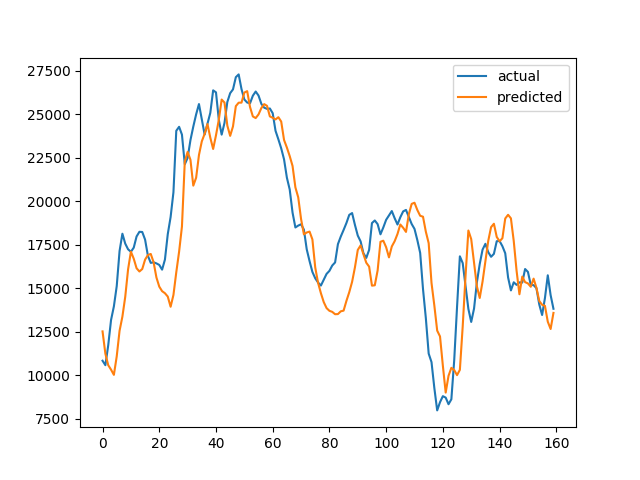

In [26]:
plot_comparison(lstm_model.predict(tst_fea_pdf.values), tst_tgt_ser.values)

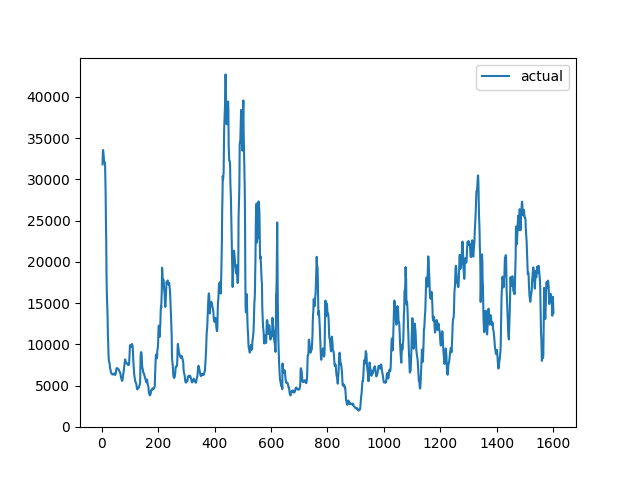

In [27]:
plot_actual(fea_tgt_pdf.target)